In [18]:
import numpy as np
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import empymod
import discretize
import  os

In [19]:
import torch
import torch.nn.functional as F
from torch.autograd.functional import jacobian
eps = torch.finfo(torch.float32).eps
print(eps)

1.1920928955078125e-07


In [20]:
from masa_utils import PsuedoLog
from masa_utils import Debye_sum_res_f
from masa_utils import InducedPolarizationSimulation as IP_np
from masa_utils import Optimization as opt_np
from masa_utils_pytorch import InducedPolarizationSimulation
from masa_utils_pytorch import Pelton_res_f, Debye_sum_f,ColeCole_f
from masa_utils_pytorch import Optimization

# multiple reference models Pelton model

In [21]:
# low time constant 
tau_true=0.1
parm_true = torch.tensor([np.log(0.2), 0.50, np.log(tau_true), 0.5], dtype=torch.float) #, requires_grad=False)
# inital reference model
np_mvec_true = parm_true.detach().numpy()

parm_ref1 = torch.tensor([np.log(0.22), 0.1, np.log(0.05), 0.6], dtype=torch.float, requires_grad=True) #, requires_grad=False)
parm_ref2 = torch.tensor([np.log(0.22), 0.1, np.log(0.2), 0.6], dtype=torch.float, requires_grad=True) #, requires_grad=False)
parm_ref3 = torch.tensor([np.log(0.22), 0.1, np.log(0.05), 0.4], dtype=torch.float, requires_grad=True) #, requires_grad=False)
parm_ref4 = torch.tensor([np.log(0.22), 0.1, np.log(0.2), 0.4], dtype=torch.float, requires_grad=True) #, requires_grad=False)

nref= 4
parm_ref = [parm_ref1, parm_ref2, parm_ref3, parm_ref4]

# Define Spectrum IP

In [22]:
nfreq = 71
freqstrt_log = -2
freqend_log = 5
freq = np.logspace(-2, 5, nfreq)

freq_plot = freq
print(freq.shape)
print(freq)

(71,)
[1.00000000e-02 1.25892541e-02 1.58489319e-02 1.99526231e-02
 2.51188643e-02 3.16227766e-02 3.98107171e-02 5.01187234e-02
 6.30957344e-02 7.94328235e-02 1.00000000e-01 1.25892541e-01
 1.58489319e-01 1.99526231e-01 2.51188643e-01 3.16227766e-01
 3.98107171e-01 5.01187234e-01 6.30957344e-01 7.94328235e-01
 1.00000000e+00 1.25892541e+00 1.58489319e+00 1.99526231e+00
 2.51188643e+00 3.16227766e+00 3.98107171e+00 5.01187234e+00
 6.30957344e+00 7.94328235e+00 1.00000000e+01 1.25892541e+01
 1.58489319e+01 1.99526231e+01 2.51188643e+01 3.16227766e+01
 3.98107171e+01 5.01187234e+01 6.30957344e+01 7.94328235e+01
 1.00000000e+02 1.25892541e+02 1.58489319e+02 1.99526231e+02
 2.51188643e+02 3.16227766e+02 3.98107171e+02 5.01187234e+02
 6.30957344e+02 7.94328235e+02 1.00000000e+03 1.25892541e+03
 1.58489319e+03 1.99526231e+03 2.51188643e+03 3.16227766e+03
 3.98107171e+03 5.01187234e+03 6.30957344e+03 7.94328235e+03
 1.00000000e+04 1.25892541e+04 1.58489319e+04 1.99526231e+04
 2.51188643e+04 3.

In [23]:
IP_model = Pelton_res_f(freq=freq)
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")


In [24]:
dobs_clean=sim.dpred(parm_true).detach()
f_abs = abs(IP_model.f(parm_true)).detach().numpy()
print(f_abs.max(),f_abs.min())
relative_error = torch.tensor(0.02)

noise_floor = torch.tensor(f_abs.max() * 1e-3)
torch.random.seed()
dobs =  dobs_clean + torch.rand(len(dobs_clean)) * torch.sqrt(
        (relative_error * abs(dobs_clean))**2 
        + (noise_floor*torch.ones(len(dobs_clean)))**2
    )

0.19449106 0.10028248


In [25]:
opt = Optimization(sim=sim, dobs=dobs)
Wd =opt.get_Wd(ratio=relative_error, plateau=noise_floor)
# opt.Wd = torch.diag(torch.ones(len(dobs)))
opt.Ws = torch.eye(4)

In [26]:
print(torch.diag(opt.Wd))

tensor([ 256.7302,  257.2878,  258.4242,  256.5995,  259.4659,  259.9959,
         259.0647,  264.3639,  265.2291,  267.0954,  271.3769,  273.2177,
         273.8530,  278.7286,  283.0894,  288.0711,  293.0241,  298.0375,
         304.5795,  307.7820,  317.7615,  321.5409,  329.4551,  334.1742,
         345.0380,  351.5669,  358.3587,  366.0703,  374.7319,  385.5473,
         394.7582,  399.0850,  405.3190,  415.7003,  420.5609,  425.4221,
         433.9668,  442.2476,  442.4483,  449.1719,  453.7253,  459.3991,
         462.6345,  467.9916,  469.2719,  467.9693,  467.3575,  474.6292,
         479.8287,  480.7915,  475.6978,  476.1231,  480.8449,  485.8410,
         486.7003,  485.4459,  484.0205,  482.1010,  488.8097,  491.7010,
         492.5112,  484.1711,  489.6613,  486.5577,  485.6038,  493.8996,
         488.2555,  488.7688,  495.2303,  495.4028,  492.2481, 4577.6743,
        4478.4302, 4356.7368, 4257.0391, 4129.0229, 3944.1196, 3819.8506,
        3674.7546, 3509.5981, 3318.520

In [27]:
niter = 80
stol=1e-6
coolingFactor = 2.0
coolingRate = 2
mu=1e-3
beta0_ratio = 1

In [28]:
models_rec = []
dpreds = []
errors_prg = []
models_prg = []
dinit_refs = []
for i in range(nref):
    parm_init = parm_ref[i]
    beta0 = opt.BetaEstimate_byEig(
        m=parm_init,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)
    print(beta0)
    mpred = opt.GradientDescent(stol=stol,l1reg=True,
    coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
        mvec_init=parm_init,niter=niter,beta0=beta0,
        update_Wsen=True,ELS=True, BLS=True)
    dinit_refs.append(opt.dpred(parm_init))
    models_rec.append(mpred)
    dpreds.append(opt.dpred(mpred))
    errors_prg.append(opt.error_prg)
    models_prg.append(opt.mvec_prg)


tensor(1.7047e+09)
  1, beta:1.7e+09, step:9.5e-07, gradient:3.6e+05,  f:6.3e+04


  2, beta:1.7e+09, step:9.5e-07, gradient:2.2e+09,  f:4.3e+06
  3, beta:8.5e+08, step:1.9e-06, gradient:1.1e+09,  f:6.5e+04
  4, beta:8.5e+08, step:9.5e-07, gradient:1.1e+09,  f:1.1e+06
  5, beta:4.3e+08, step:1.9e-06, gradient:5.4e+08,  f:6.5e+04
  6, beta:4.3e+08, step:9.5e-07, gradient:5.4e+08,  f:3.3e+05
  7, beta:2.1e+08, step:1.9e-06, gradient:2.7e+08,  f:6.4e+04
  8, beta:2.1e+08, step:9.5e-07, gradient:2.7e+08,  f:1.3e+05
  9, beta:1.1e+08, step:1.9e-06, gradient:1.4e+08,  f:6.3e+04
 10, beta:1.1e+08, step:9.5e-07, gradient:1.3e+08,  f:7.9e+04
 11, beta:5.3e+07, step:1.9e-06, gradient:6.8e+07,  f:6.3e+04
 12, beta:5.3e+07, step:9.5e-07, gradient:6.7e+07,  f:6.6e+04
 13, beta:2.7e+07, step:1.9e-06, gradient:3.4e+07,  f:6.3e+04
 14, beta:2.7e+07, step:9.5e-07, gradient:3.3e+07,  f:6.4e+04
 15, beta:1.3e+07, step:1.9e-06, gradient:1.7e+07,  f:6.3e+04
 16, beta:1.3e+07, step:9.5e-07, gradient:1.6e+07,  f:6.3e+04
 17, beta:6.7e+06, step:9.5e-07, gradient:8.8e+06,  f:6.3e+04
 18, bet

In [29]:
print( "Parameter:     res0,   chg,       tau,     c")

for i in range(nref):
    np_mvec_ref = parm_ref[i].detach().numpy()
    np_mvec_est = models_rec[i].detach().numpy()
    print(f"ref{i+1}     & {np.exp(np_mvec_ref[0]):.2e} & {np_mvec_ref[1]:.3f} & {np.exp(np_mvec_ref[2]):.2e} & {np_mvec_ref[3]:.3f}")
    print(f"est{i+1}     & {np.exp(np_mvec_est[0]):.2e} & { np_mvec_est[1]:.3f} & { np.exp(np_mvec_est[2]):.2e} & { np_mvec_est[3]:.3f}")
print(f"true     & {np.exp(np_mvec_true[0]):.2e} & {np_mvec_true[1]:.3f} & {np.exp(np_mvec_true[2]):.2e} & {np_mvec_true[3]:.3f}")

Parameter:     res0,   chg,       tau,     c
ref1     & 2.20e-01 & 0.100 & 5.00e-02 & 0.600
est1     & 2.00e-01 & 0.493 & 9.96e-02 & 0.504
ref2     & 2.20e-01 & 0.100 & 2.00e-01 & 0.600
est2     & 2.00e-01 & 0.496 & 1.04e-01 & 0.501
ref3     & 2.20e-01 & 0.100 & 5.00e-02 & 0.400
est3     & 2.00e-01 & 0.492 & 9.99e-02 & 0.503
ref4     & 2.20e-01 & 0.100 & 2.00e-01 & 0.400
est4     & 2.00e-01 & 0.493 & 1.03e-01 & 0.502
true     & 2.00e-01 & 0.500 & 1.00e-01 & 0.500


In [30]:
dest_abs_np =[]
dest_phase_np =[]
dest_real_np =[]
dest_imag_np =[]
dinit_abs_np =[]
dinit_phase_np =[]
for i in range(nref):
    dest = dpreds[i].detach().numpy()
    dinit = dinit_refs[i].detach().numpy()
    dest_real = dest[:nfreq]
    dest_imag = dest[nfreq:]
    dinit_real = dinit[:nfreq]
    dinit_imag = dinit[nfreq:]
    dest_abs = np.abs(dest_real + 1j * dest_imag)
    dest_phase = np.angle(dest_real + 1j * dest_imag, deg=True)
    dinit_abs = np.abs(dinit_real + 1j * dinit_imag) 
    dinit_phase = np.angle(dinit_real + 1j * dinit_imag, deg=True)
    dest_real_np.append(dest_real)
    dest_imag_np.append(dest_imag)
    dest_abs_np.append(dest_abs)
    dest_phase_np.append(dest_phase)
    dinit_abs_np.append(dinit_abs)
    dinit_phase_np.append(dinit_phase)
dobs_np = dobs.detach().numpy()
dobs_real = dobs_np[:nfreq]
dobs_imag = dobs_np[nfreq:]
dobs_abs = np.abs(dobs_real + 1j * dobs_imag)
dobs_phase = np.angle(dobs_real + 1j * dobs_imag, deg=True)


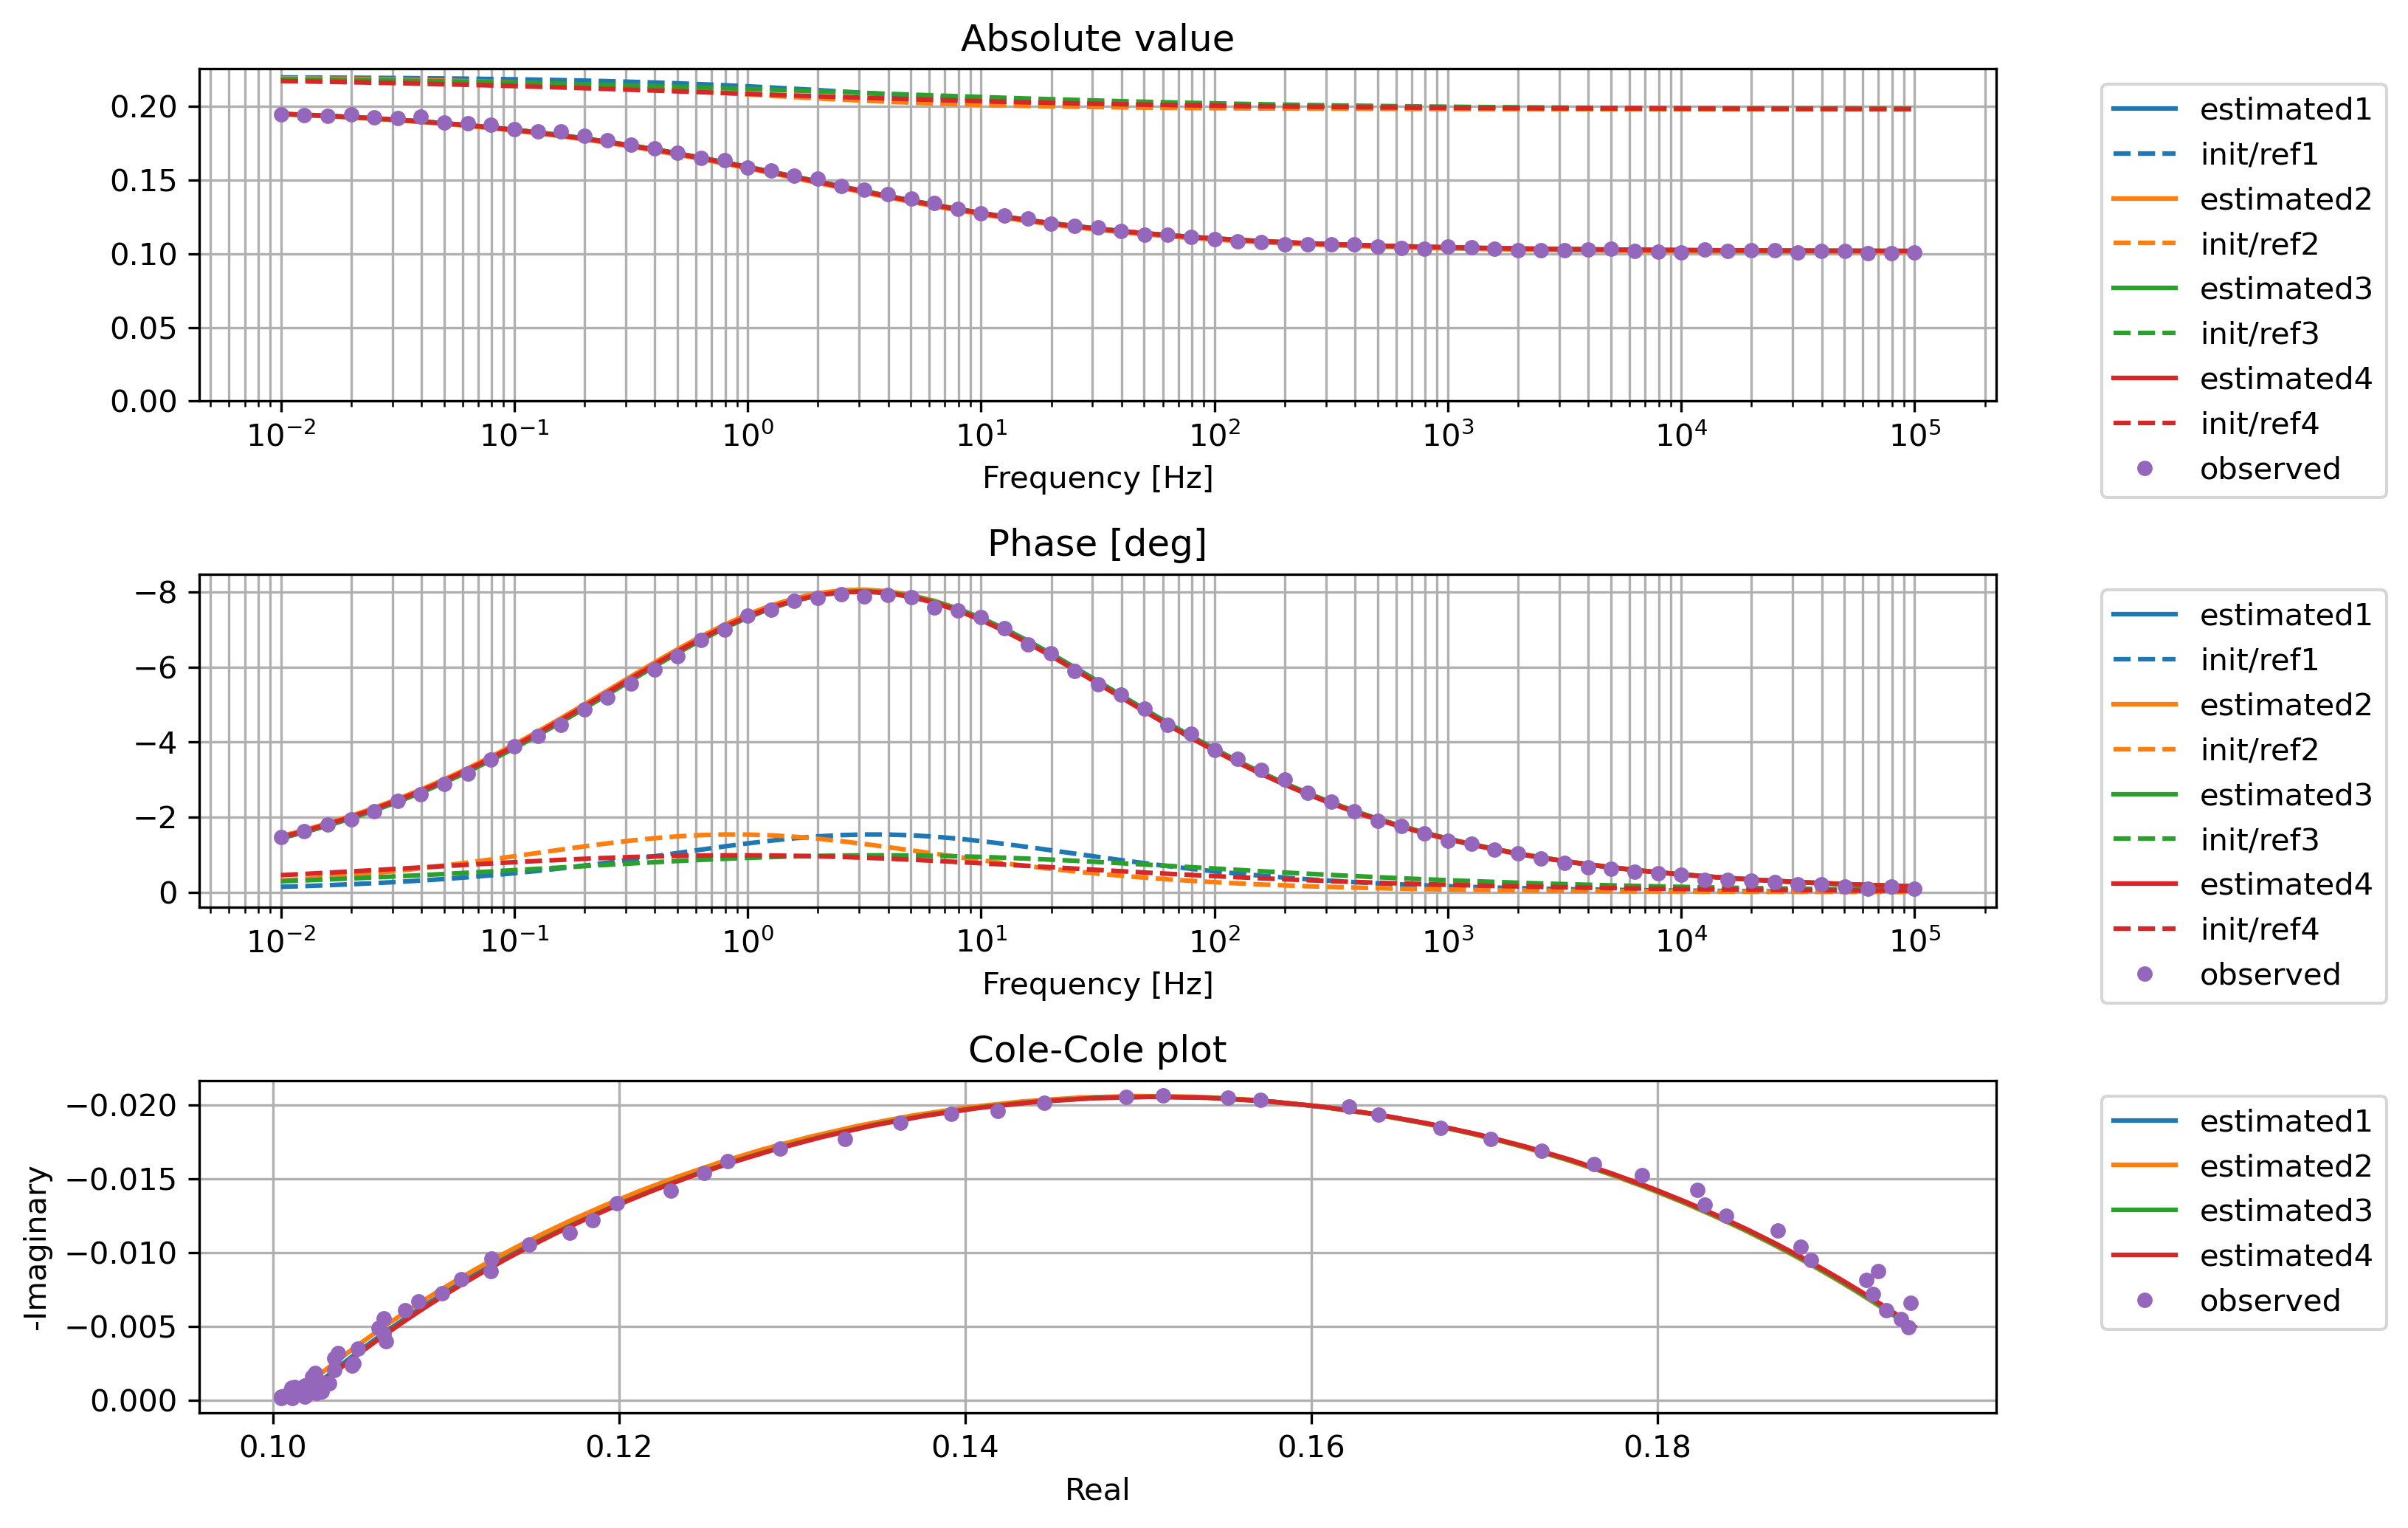

In [31]:
fig, ax = plt.subplots(3, 1, figsize=(11,7),dpi=300)
for i in range(nref):
    dest_abs = dest_abs_np[i]
    dest_phase = dest_phase_np[i]
    dest_real = dest_real_np[i]
    dest_imag = dest_imag_np[i]
    dinit_abs = dinit_abs_np[i] 
    dinit_phase = dinit_phase_np[i]
    ax[0].semilogx(freq_plot, dest_abs, color=f"C{i}", label=f"estimated{i+1}")
    ax[0].semilogx(freq_plot, dinit_abs, color=f"C{i}", linestyle="--", label=f"init/ref{i+1}")
    ax[1].semilogx(freq_plot, dest_phase, color=f"C{i}", label=f"estimated{i+1}")
    ax[1].semilogx(freq_plot, dinit_phase, color=f"C{i}", linestyle="--", label=f"init/ref{i+1}")
    ax[2].plot(dest_real, dest_imag, color=f"C{i}", label=f"estimated{i+1}")
ax[0].semilogx(freq_plot, dobs_abs, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="observed")
ax[0].set_ylim(bottom=0)
ax[1].semilogx(freq_plot, dobs_phase, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="observed")
ax[2].plot(dobs_real, dobs_imag, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="observed")
ax[1].invert_yaxis()
ax[2].invert_yaxis()
for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_title("Absolute value")
ax[1].set_title("Phase [deg]")
ax[2].set_title("Cole-Cole plot")
ax[2].set_xlabel("Real")
ax[2].set_ylabel("-Imaginary")
plt.tight_layout()
plt.savefig("18_Pelton_res_sip.jpg", dpi=300)

In [32]:
U_pelton = []
S_pelton=[]
S_pelton_norm = []
V_pelton=[]
for i in range(nref):
    J_np = opt.J(models_rec[i]).detach().numpy()
    U, S, V = np.linalg.svd(J_np, full_matrices=False)
    U_pelton.append(U)
    S_pelton.append(S)
    s_norm = S/S.max()
    S_pelton_norm.append(s_norm)
    V_pelton.append(V)


# Linearly Wighted Debye model

In [33]:
ntau= 9
taus = np.logspace(-5,1,ntau)
print(taus)

[1.00000000e-05 5.62341325e-05 3.16227766e-04 1.77827941e-03
 1.00000000e-02 5.62341325e-02 3.16227766e-01 1.77827941e+00
 1.00000000e+01]


In [34]:
IP_model = Debye_sum_f(freq=freq, ntau=ntau, taus=taus)
# IP_model = Pelton_debye_f(freq=freq, ntau=ntau)
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")

In [35]:
parm_init = torch.tensor(
    # np.r_[np.log(0.2), 0.01*np.ones(ntau)],
    np.r_[np.log(0.22), 0.01*np.ones(ntau)],
    dtype=torch.float32,
    requires_grad=True
) #, requires_grad=False)
# parm_init = torch.tensor(np.r_[np.log(0.3), np.zeros(ntau), np.log(taus)], 
#                 dtype=torch.float32, requires_grad=True) #, requires_grad=False)
mvec_init = parm_init.detach().numpy()
dinit = sim.dpred(parm_init).detach()

In [ ]:
opt = Optimization(sim=sim, dobs=dobs)
Wd =opt.get_Wd(ratio=relative_error, plateau=noise_floor)
opt.Ws = torch.eye(len(parm_init))
beta0 = opt.BetaEstimate_byEig(
    m=parm_init,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)

In [37]:
mpred = opt.GradientDescent(stol=stol,
coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,l1reg=True,
    mvec_init=parm_init,niter=niter,beta0=beta0, update_Wsen=True,
    ELS=True, BLS=True)

  1, beta:4.7e+09, step:9.5e-07, gradient:8.6e+05,  f:7.3e+04
  2, beta:4.7e+09, step:9.5e-07, gradient:1.2e+10,  f:2.0e+07
  3, beta:2.4e+09, step:1.9e-06, gradient:5.9e+09,  f:7.4e+04
  4, beta:2.4e+09, step:9.5e-07, gradient:5.9e+09,  f:5.0e+06
  5, beta:1.2e+09, step:1.9e-06, gradient:2.9e+09,  f:7.4e+04
  6, beta:1.2e+09, step:9.5e-07, gradient:2.9e+09,  f:1.3e+06
  7, beta:5.9e+08, step:1.9e-06, gradient:1.5e+09,  f:7.3e+04
  8, beta:5.9e+08, step:9.5e-07, gradient:1.5e+09,  f:3.8e+05
  9, beta:3.0e+08, step:1.9e-06, gradient:7.3e+08,  f:7.3e+04
 10, beta:3.0e+08, step:9.5e-07, gradient:7.3e+08,  f:1.5e+05
 11, beta:1.5e+08, step:1.9e-06, gradient:3.7e+08,  f:7.2e+04
 12, beta:1.5e+08, step:9.5e-07, gradient:3.7e+08,  f:9.0e+04
 13, beta:7.4e+07, step:1.9e-06, gradient:1.8e+08,  f:7.2e+04
 14, beta:7.4e+07, step:9.5e-07, gradient:1.8e+08,  f:7.6e+04
 15, beta:3.7e+07, step:1.9e-06, gradient:9.2e+07,  f:7.2e+04
 16, beta:3.7e+07, step:9.5e-07, gradient:9.1e+07,  f:7.3e+04
 17, bet

In [38]:
np_mvec_prg = opt.mvec_prg
np_mvec_init = parm_init.detach().numpy()
np_mvec_true = parm_true.detach().numpy()
np_mvec_est = mpred.detach().numpy()
dest = opt.dpred(mpred)
mvec_pred = mpred.detach().numpy()
#taus = np.exp(mvec_pred[1+ntau:])

In [39]:
print(f"initial :{np.exp(np_mvec_init[0]):.2e}, {np_mvec_init[1].sum():.3f}")
print(f"est     :{np.exp(np_mvec_est[0]):.2e}, { np_mvec_est[1:].sum():.3f}")
print(f"true    :{np.exp(np_mvec_true[0]):.2e}, {np_mvec_true[1]:.3f}, {np.exp(np_mvec_true[2]):.2e}, {np_mvec_true[3]:.3f}")


initial :2.20e-01, 0.010
est     :1.97e-01, 0.483
true    :2.00e-01, 0.500, 1.00e-01, 0.500


In [40]:

dest_real = dest[:nfreq].detach().numpy().flatten()
dest_imag = dest[nfreq:].detach().numpy().flatten()
dest_abs = np.abs(dest_real+ 1.0j*dest_imag)
dest_phase = np.angle(dest_real+ 1.0j*dest_imag, deg=True) # -1000*np.arctan2(dest_imag, dest_real)
dobs_real = dobs[:nfreq].detach().numpy().flatten()
dobs_imag = dobs[nfreq:].detach().numpy().flatten()
dobs_abs = np.abs(dobs_real+ 1.0j*dobs_imag)
dobs_phase = np.angle(dobs_real+ 1.0j*dobs_imag, deg=True) 
dinit_real = dinit[:nfreq].detach().numpy().flatten()
dinit_imag = dinit[nfreq:].detach().numpy().flatten()
dinit_abs = np.abs(dinit_real+ 1.0j*dinit_imag)
dinit_phase =  np.angle(dinit_real+ 1.0j*dinit_imag, deg=True)


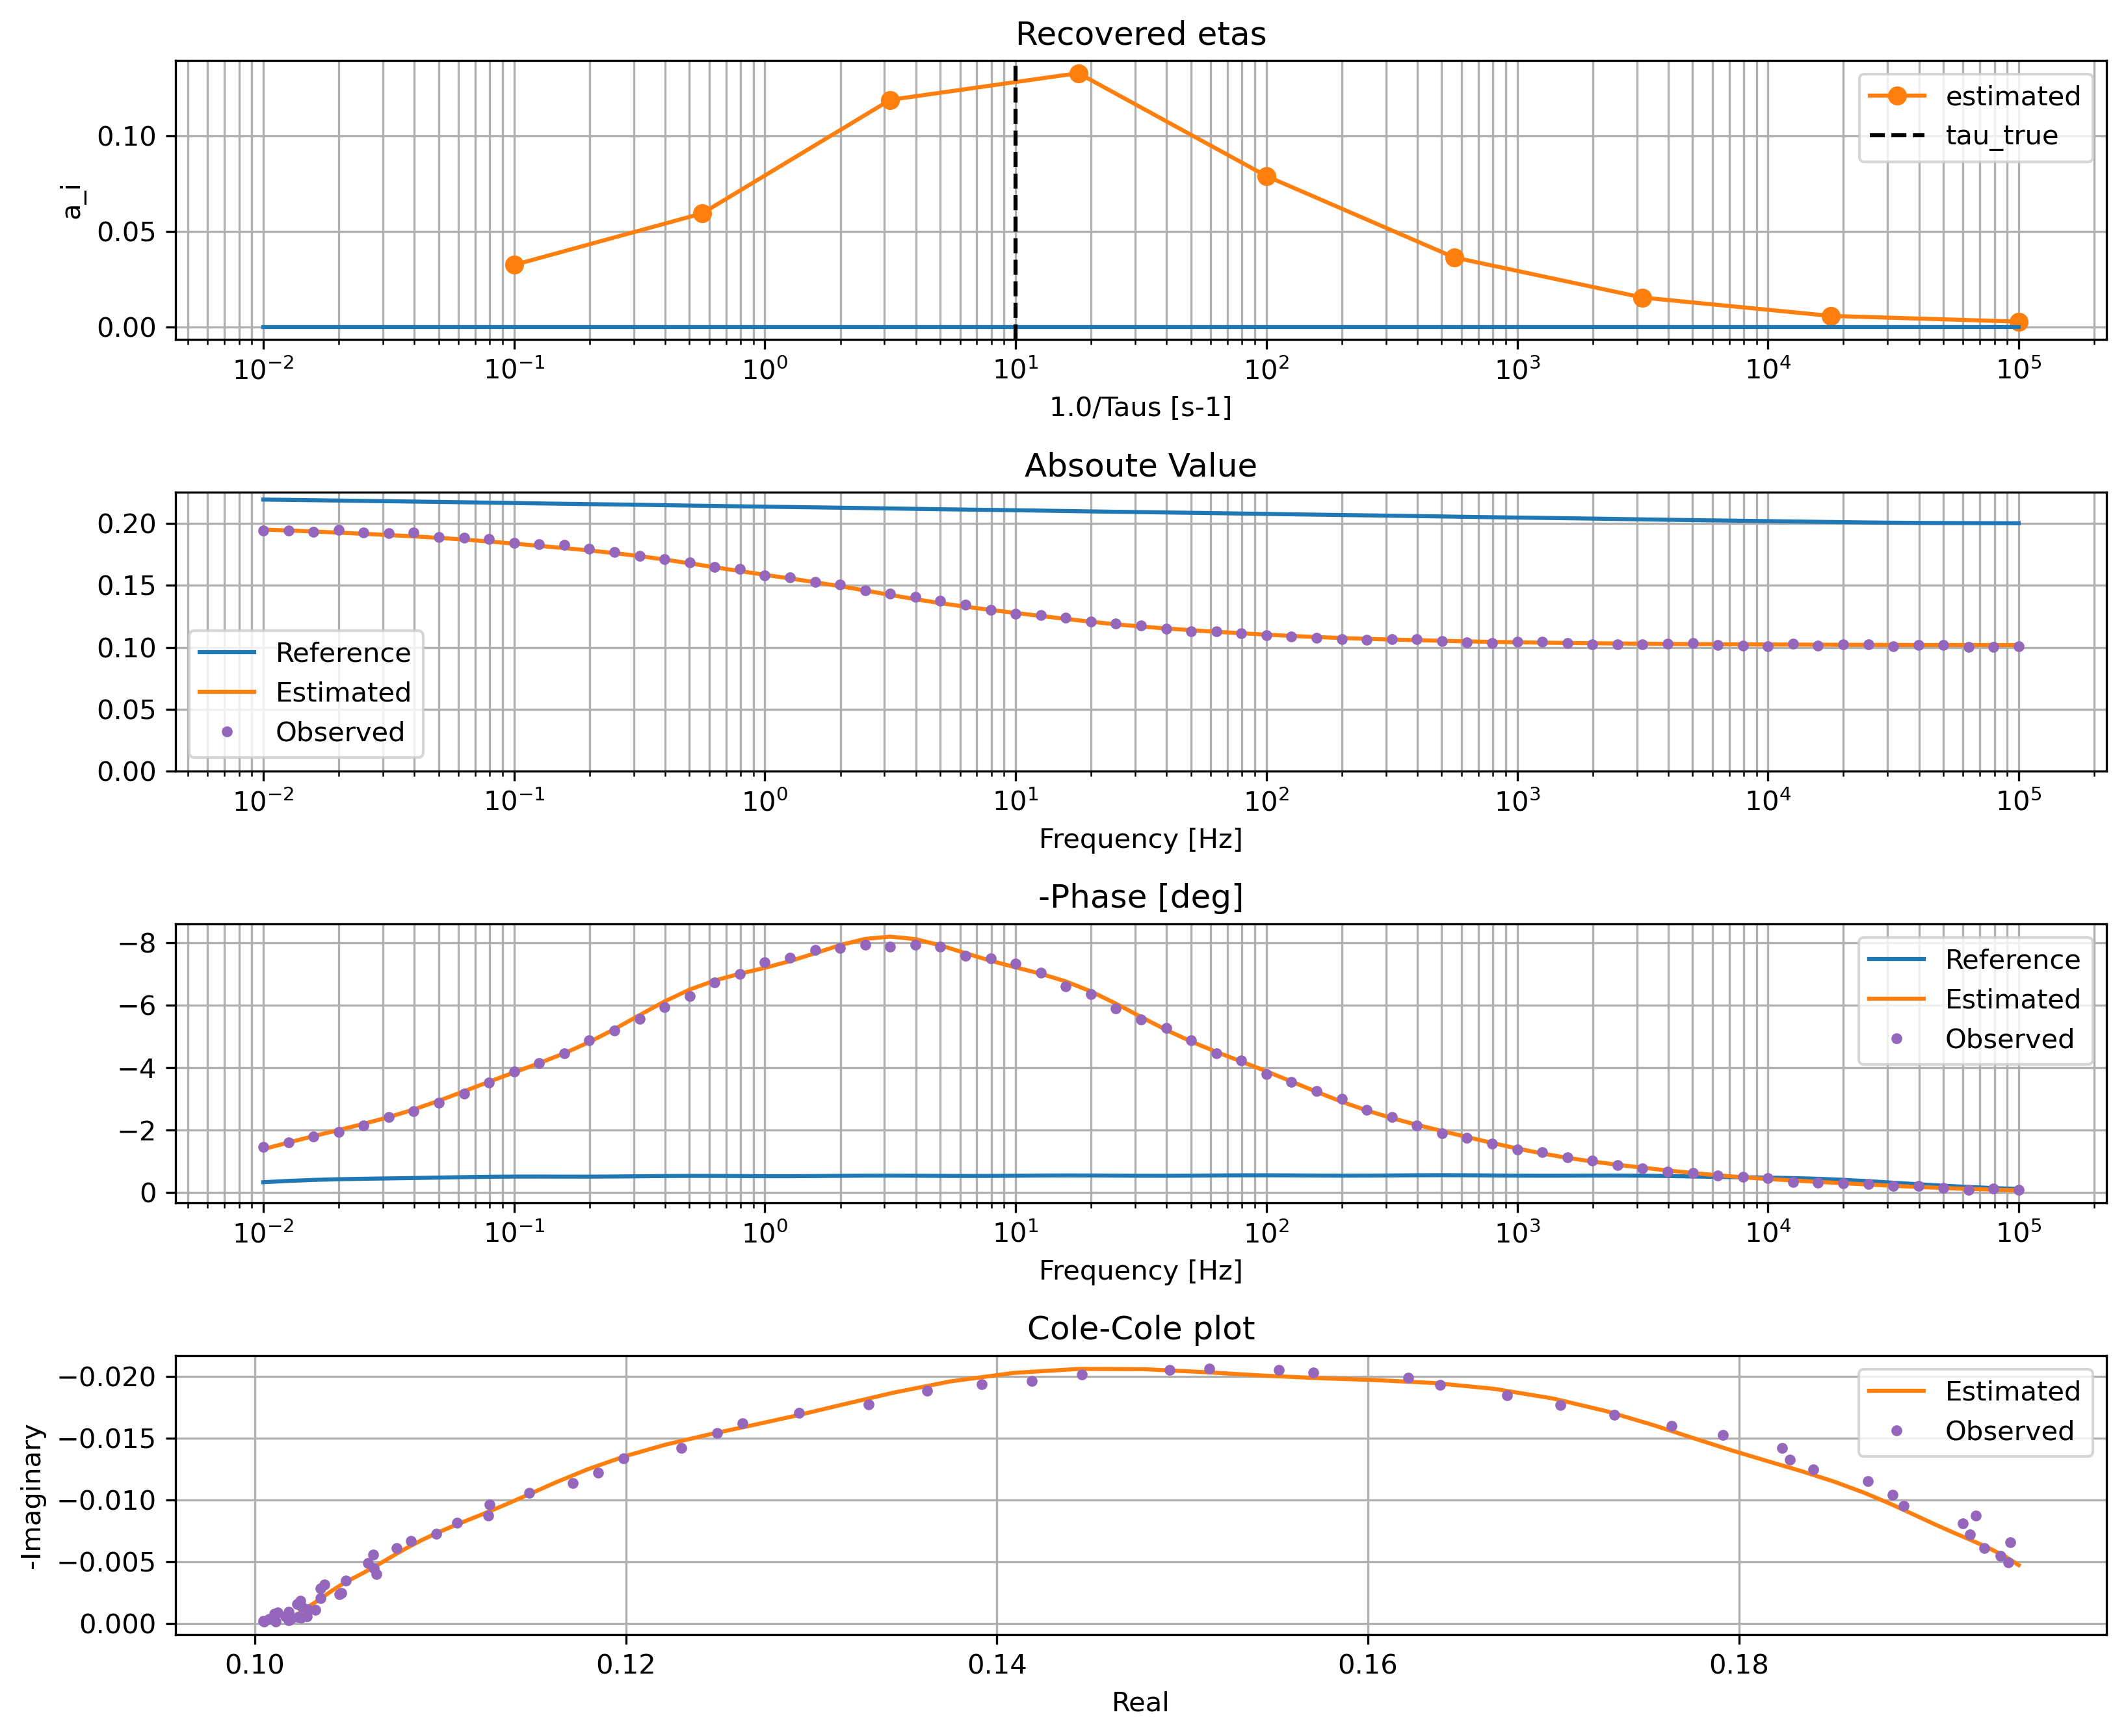

In [41]:
fig, ax = plt.subplots(4, 1, figsize=(11,9),dpi=300)

ax[0].semilogx(1/taus, mvec_pred[1:1+ntau], color="C1", marker="o",label="estimated")
ax[0].semilogx(np.r_[freq_plot.min(),freq_plot.max()], np.r_[0,0])
ax[0].axvline(x=1/tau_true, color="k", linestyle="--", label="tau_true")

ax[1].semilogx(freq_plot, dinit_abs, color="C0", label="Reference")
ax[1].semilogx(freq_plot, dest_abs, color="C1", label="Estimated")
ax[1].semilogx(freq_plot, dobs_abs, color=f"C{nref}", linestyle="", marker=".", label="Observed")

ax[1].set_ylim(bottom=0)
ax[2].semilogx(freq_plot, dinit_phase, color="C0", label="Reference")
ax[2].semilogx(freq_plot, dest_phase, color="C1", label="Estimated")
ax[2].semilogx(freq_plot, dobs_phase, color=f"C{nref}", linestyle="", marker=".", label="Observed")
# ax[3].plot(dinit_real, -dest_imag, color="C0", label="Initial")
ax[2].invert_yaxis()
ax[3].plot(dest_real, dest_imag, color="C1", label="Estimated")
ax[3].plot(dobs_real, dobs_imag, color=f"C{nref}", linestyle="", marker=".", label="Observed")
ax[3].invert_yaxis()

for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend()
ax[0].set_xlabel("1.0/Taus [s-1]")
ax[0].set_ylabel("a_i")
ax[0].set_title("Recovered etas")
ax[1].set_title('Absoute Value')
ax[2].set_title('-Phase [deg]')
ax[3].set_title("Cole-Cole plot")
ax[3].set_xlabel("Real")
ax[3].set_ylabel("-Imaginary")
plt.tight_layout()
plt.savefig("18_Debye_sum_sip.jpg", dpi=300)

In [42]:
jacobian = sim.J(mpred)
j_plot_real = jacobian[:nfreq].detach().numpy()
j_plot_imag = jacobian[nfreq:].detach().numpy()
print(j_plot_imag.shape)
print(j_plot_real.shape)

(71, 10)
(71, 10)


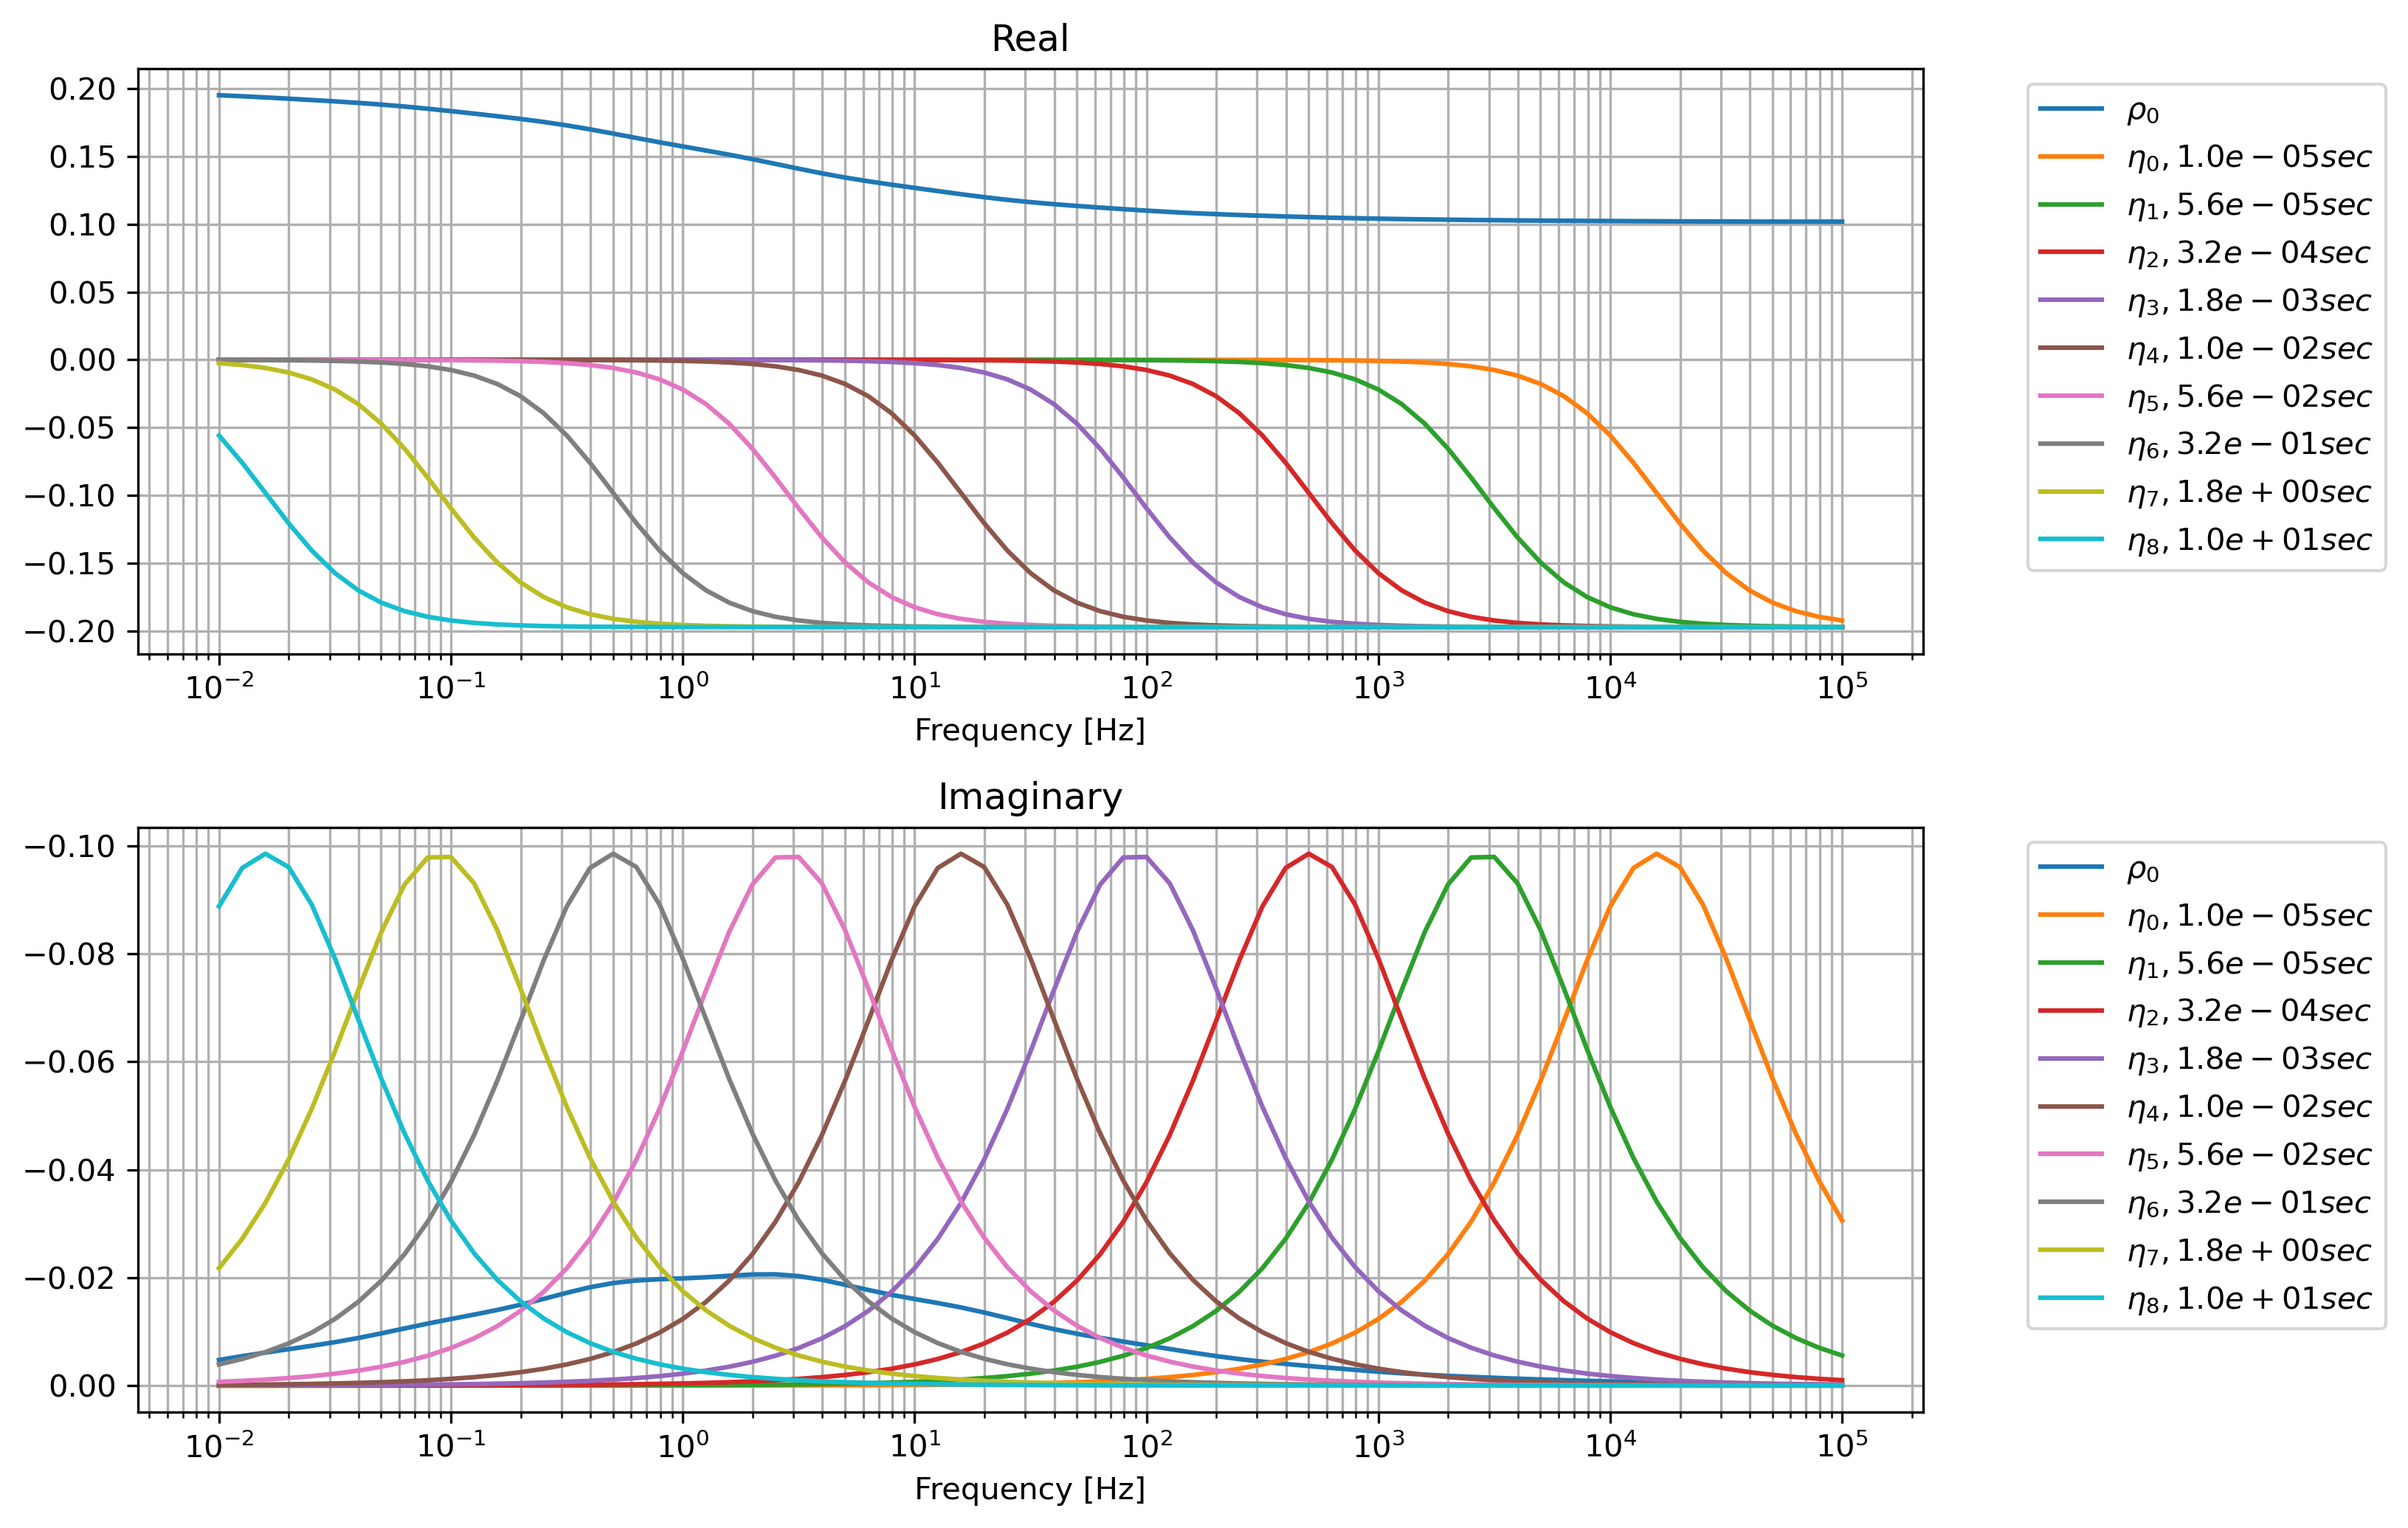

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(11, 7),dpi=300)

ax[0].semilogx(freq_plot, j_plot_real[:,0], color="C0", 
               label=r"$\rho_0$")
ax[1].semilogx(freq_plot, j_plot_imag[:,0], color="C0",
               label=r"$\rho_0$")
for i in range(ntau):
    ax[0].semilogx(freq_plot, j_plot_real[:,i+1], color=f"C{i+1}", 
                   label=f"$\eta_{i}, {taus[i]:.1e} sec$")
    ax[1].semilogx(freq_plot, j_plot_imag[:,i+1], color=f"C{i+1}",
                     label=f"$\eta_{i}, {taus[i]:.1e} sec$")
ax[1].invert_yaxis()

for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_title('Real')
ax[1].set_title('Imaginary')
plt.tight_layout()
plt.savefig("18_Debye_sum_sip_jacobian.jpg", dpi=300)

# Compare Singular Value of Jacobian

In [44]:
J_np = jacobian.detach().numpy()
U, S, V = np.linalg.svd(J_np, full_matrices=False)
S_LWD = S/S.max()

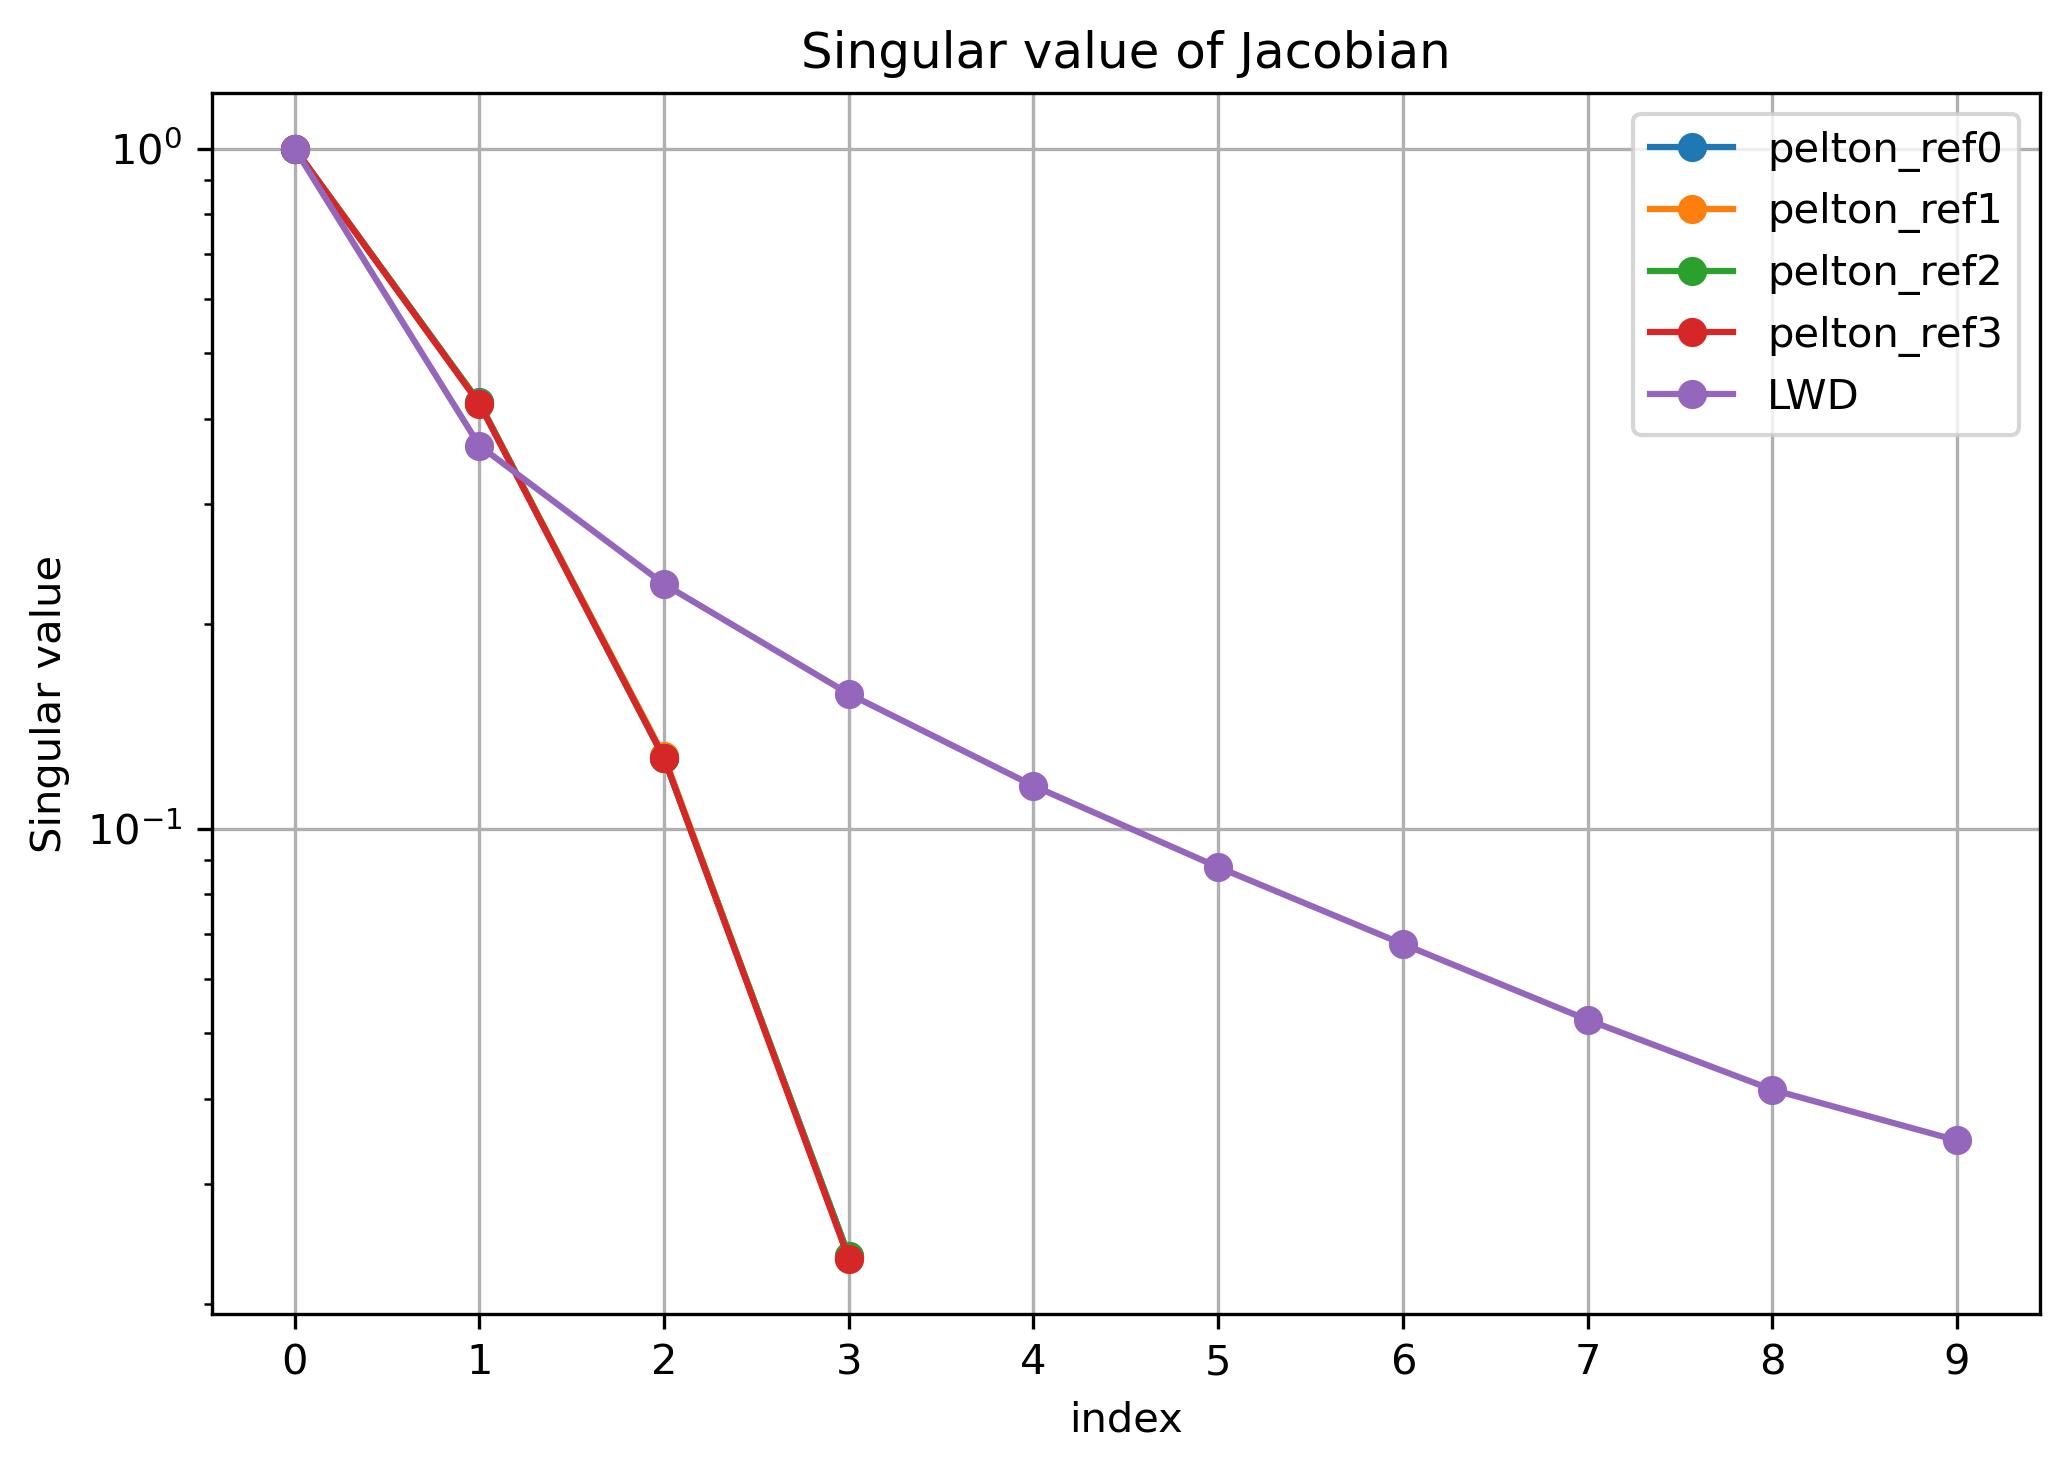

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=300)
for i in range(nref):
    ax.semilogy(S_pelton_norm[i], label=f'pelton_ref{i}', marker="o")
ax.semilogy(S_LWD, label='LWD', marker="o")
ax.set_xticks(range(ntau+1))
ax.grid()
ax.legend()
ax.set_xlabel("index")
ax.set_ylabel("Singular value")
ax.set_title("Singular value of Jacobian")
plt.tight_layout()
# plt.savefig("18_Debye_sum_sip_singular.jpg", dpi=300)

In [51]:
np.savez("18_SingularValue.npz", 
         Pelton=S_pelton_norm,
         LWD=S_LWD,
         taus=taus)


In [49]:
taus

array([1.00000000e-05, 5.62341325e-05, 3.16227766e-04, 1.77827941e-03,
       1.00000000e-02, 5.62341325e-02, 3.16227766e-01, 1.77827941e+00,
       1.00000000e+01])